# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): E109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(9001)

# read in data
path = '/Volumes/EMTEC/Harvard/HW6/' # 'D:/Harvard/HW6/' # '/Volumes/EMTEC/Harvard/HW6/'
df = pd.read_csv(path + 'hw6_dataset.csv', header=None)

def train_test_split_shape(df, x_cols, y_col, train_size=.75):
    '''
    Inputs:
    ------------------------------------------------------
    df: full pd.DataFrame to be split into train/test groups
    x_cols: list of columns in pd.DataFrame that are predictors
    y_col: name of label column
    train_size: percentage of the dataset for training split
    
    Outputs:
    ------------------------------------------------------
    x_train, x_test, y_train, y_test
    '''
    # split data
    x_train, x_test, y_train, y_test = train_test_split(df[x_cols], df[y_col], train_size=train_size)

    print('''
    Shape of Training Data w/ Missing Values:
    ------------------------------------------------------
    X: %s
    Y: %s

    Shape of Testing Data w/ Missing Values:
    ------------------------------------------------------
    X: %s
    Y: %s
    ''' %(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
    
    return {'x_train':x_train, 'x_test':x_test, 'y_train':y_train, 'y_test':y_test}

# compile data into sets for tracking
datasets = {}
datasets['complete'] = train_test_split_shape(df, df.columns[:-1], df.columns[-1], train_size=0.75)


    Shape of Training Data w/ Missing Values:
    ------------------------------------------------------
    X: (51823, 117)
    Y: (51823,)

    Shape of Testing Data w/ Missing Values:
    ------------------------------------------------------
    X: (17275, 117)
    Y: (17275,)
    


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss

# id parameters
param_grid = {'C': [.0001, .001, .01, .1, 1, 10, 100, 1000]}#{'C': [.0001, .001, .01, .1, 1, 10, 100, 1000]}

# gridsearch to find best C value
logit = LogisticRegression(penalty='l2')
logit = GridSearchCV(logit, param_grid)

# fit logistic regression on training set and report metrics
logit.fit(datasets['complete']['x_train'], datasets['complete']['y_train'])
yhat_logit = logit.predict(datasets['complete']['x_test'])
yhat_zeros = phat_zeros = np.zeros(len(datasets['complete']['x_test']))

# get misclassification rate
misclass_logit = 1 - zero_one_loss(datasets['complete']['y_test'], yhat_logit)
misclass_zeros = 1 - zero_one_loss(datasets['complete']['y_test'], yhat_zeros)

print('''
Misclassification Logistic Regression = %.5f
Misclassification Predicting All Normal = %.5f
''' %(misclass_logit, misclass_zeros))


Misclassification Logistic Regression = 0.99560
Misclassification Predicting All Normal = 0.99467



In [4]:
# get confusion matrices
def binary_confusion_matrix(y, yhat, model_name='unspecified'):
    '''
    Inputs:
    ------------------------------------------------------
    y: true labels (1, 0)
    yhat: predicted labels (1, 0)
    model_name: name of model for printing
    
    Outputs:
    ------------------------------------------------------
    cm: confusion matrix (easily readable)
    metrics: dict of metrics on binary classification
    '''
    # organize confusion matrix from sklearn into readable format
    sk_confusion_matrix = confusion_matrix(y, yhat, labels=[0, 1]).transpose()#; print(sk_confusion_matrix)
    IX, COLS = ['TestNegative', 'TestPositive'], ['Negative', 'Positive']
    cm = pd.DataFrame(sk_confusion_matrix, \
                      columns=COLS, \
                      index=IX)
    cm['Total'] = cm.sum(axis=1)
    cm.loc['Total'] = cm.sum(axis=0)
    
    # get performance scores
    ACC = np.divide(np.diag(cm.loc[IX, COLS]).sum(), cm.loc[IX, COLS].sum().sum())
    MCR = 1 - ACC
    FPR = np.divide(cm.loc['TestPositive', 'Negative'], cm.loc['Total', 'Negative'])
    FNR = np.divide(cm.loc['TestNegative', 'Positive'], cm.loc['Total', 'Positive'])
    TPR = np.divide(cm.loc['TestPositive', 'Positive'], cm.loc['Total', 'Positive'])
    TNR = np.divide(cm.loc['TestNegative', 'Negative'], cm.loc['Total', 'Negative'])
    PR = np.divide(cm.loc['Total', 'Positive'], cm.loc['Total', 'Total'])
    PPV = np.divide(cm.loc['TestPositive', 'Positive'], cm.loc['TestPositive', 'Total'])
    NPV = np.divide(cm.loc['TestNegative', 'Negative'], cm.loc['TestNegative', 'Total'])
    FDR = 1 - PPV
    FOR = 1 - NPV
    
    metrics = {'accuracy':ACC, 'misclassification':MCR, 'false_positive':FPR, \
              'false_negative':FNR, 'true_positive':TPR, 'true_negative':TNR,\
              'prevalence':PR, 'positive_predictive_value':PPV, 'negative_predictive_value':NPV, \
              'false_discovery_rate':FDR, 'false_omission_rate':FOR}
    
    print('''
    Confusion Matrix for Model: %s
    ------------------------------------------------------''' %model_name)
    print(cm)
    print('''
    Metrics for Model: %s
    ------------------------------------------------------
    Accuracy Rate = %.5f
    Misclassification Rate = %.5f
    False Positive Rate (Fall-Out, False Alarm, Type I Error) = %.5f
    False Negative Rate (Miss, Type II Error) = %.5f
    True Positive Rate (Sensitivity, Recall, Hit) = %.5f
    True Negative Rate (Specificity) = %.5f
    Prevalence Rate = %.5f
    Positive Predictive Value (Precision) = %.5f
    Negative Predictive Value = %.5f
    False Discovery Rate = %.5f
    False Omission Rate = %.5f
    ''' %(model_name, ACC, MCR, FPR, FNR, TPR, TNR, PR, PPV, NPV, FDR, FOR))
    
    return cm, metrics

cm_logit, metrics_logit = binary_confusion_matrix(datasets['complete']['y_test'], \
                                                  yhat_logit, model_name='Logistic Regression')
cm_zeros, metrics_zeros = binary_confusion_matrix(datasets['complete']['y_test'], \
                                                  yhat_zeros, model_name='Predicting All Normal')


    Confusion Matrix for Model: Logistic Regression
    ------------------------------------------------------
              Negative  Positive  Total
TestNegative     17176        69  17245
TestPositive         7        23     30
Total            17183        92  17275

    Metrics for Model: Logistic Regression
    ------------------------------------------------------
    Accuracy Rate = 0.99560
    Misclassification Rate = 0.00440
    False Positive Rate (Fall-Out, False Alarm, Type I Error) = 0.00041
    False Negative Rate (Miss, Type II Error) = 0.75000
    True Positive Rate (Sensitivity, Recall, Hit) = 0.25000
    True Negative Rate (Specificity) = 0.99959
    Prevalence Rate = 0.00533
    Positive Predictive Value (Precision) = 0.76667
    Negative Predictive Value = 0.99600
    False Discovery Rate = 0.23333
    False Omission Rate = 0.00400
    

    Confusion Matrix for Model: Predicting All Normal
    ------------------------------------------------------
              N

/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


### Comparing Models

Comparing the performance of logistic regression, with the `C` parameter tuned using cross validation, with the performance of simply predicting $Y=0$ regardless of $X$ different performance metrics are observed.  While both models have a high accuracy rate (99.6% for logistic and 99.5% for $Y=0$) there are more nuianced differences that demonstrate that logistic regression is a superior model.  These high accuracy rates are more a result of the prevalence of disease rather than the efficacy of the diagnostic model. 

Firstly and most obviously, predicting that all patients are "normal" will make any medical malpractice lawyer (who happens to know something about diagnostics) salivate.  While the logistic regression only correctly classifies 25% of the $T+$ population ($TPR = 0.25$) the model that predicts $Y=0$ does even worse with a $TPR = 0.00$.  This means that not a single person in the $Y=0$ model was positively identified as having cancer.  Given Type II error is highly costly to a patient, and that the $Y=0$ model doesn't even attempt to classify cancer, it is safe to conclude from this information alone that the logistic regression model is superior to making a blanket guess over all patients. 

### Analyzing the Confusion Matrices & True Positive/Negative Rates

Below are the confusion matrices as computed on the test data for both models.

--------------------------------------------
|Logistic Model|Negative  |Positive  |Total|
|--------------|----------|----------|-----|
|TestNegative  |   17176  |      69  |17245|
|TestPositive  |       7  |      23  |   30|
|Total         |   17183  |      92  |17275|
-----------------------------------------

--------------------------------------------
|$Y=0$ Model   |Negative  |Positive  |Total|
|--------------|----------|----------|-----|
|TestNegative  |   17183  |      92  |17275|
|TestPositive  |       0  |       0  |    0|
|Total         |   17183  |      92  |17275|
-----------------------------------------

As mentioned above, the logistic regression model has a $TPR = 0.25$ (since it corectly identifies only a quarter of the diseased patients) while the $Y=0$ model has a $TPR = 0.00$ (since no patient is predicted to have cancer).  These low numbers are problematic for the patients who truly do have cancer since the diagnostic has a low probability of correctly identifying them as such.  However, given the low prevalence of disease, the true negative rate for both models is very high.  For logistic regression we observe a $TNR = 0.99959$ while for the $Y = 0$ model we observe a 100% TNR.  This means that we almost always correctly identify non-disease patients as such.  Again, going back to the low prevalence of disease of 0.00533, this is misleading.  When it is known that only about 5 people in every thousand have a condition it is somewhat lazy to predict that everyone does not have the condition, especially when the condition is as serious as cancer. 

   - True Positive Rate (Logistic Regression) = 0.25000
   - True Negative Rate (Logistic Regression) = 0.99959
   - True Positive Rate (All-Normal Model) = 0.00000
   - True Negative Rate (All-Normal Model) = 1.00000

The false positive rate of the fitted classifier (logistic model) is 0.00041.  The FPR's relationship with the TNR is relatively straight forward; the false positive rate is simply the converse of the true negative rate $FPR = 1 - TNR = 0.99959$.  It is known that $FPR = \frac{FP}{FP + TN} = 1 - TNR$. It is also known that $TNR = \frac{TN}{TN + FP}$.  By substituting these terms we see that $FPR = \frac{FP}{FP + TN} = 1 - \frac{TN}{TN + FP} = 1 - TNR$.

The $FPR$'s relationship with the true positive rate $TPR$ is less intuitive because of the fact that all models are different.  The $TPR$ is the probability that the test indicates positive *when the real state of nature is in fact positive*.  [It is not possible to directly derive the $FPR$ from the $TPR$ or the $FNR$](https://stats.stackexchange.com/questions/61829/relation-between-true-positive-false-positive-false-negative-and-true-negative) because there is no information on specificity (how the diagnostic behaves *when the real state of nature is negative*) contained in the ratio.

The $FPR$'s relationship with the true positive rate $TPR$, which is 0.25 for the logistic model, is a bit loose, circuitous & ambiguous.  

On the more technical side, relationships between $FPR$ and $TPR$ exist when more atomic information is available.  One such link can be found through the false discovery rate $FDR$ and/or $PPV$.  $FDR$ quantifies the subset of positive identifications that were actually negative as a proportion of all positive identifications which, in this example, are the row sums.  Formally, $FDR = \frac{FP}{FP + TP} = 1 - PPV = 1 - \frac{TP}{TP + FP}$, where FP is the number of false positives, TP is the number of true positives, and PPV is the positive predictive value.  Both $FP$ and $TP$ are measures of positive predictions, where $FP$ is an inaccurate positive prediction and $TP$ is an accurate positive prediction.  The sum of these two numbers (identified in the `Total` column of the `TestPositive` row index in the confusion matrices) is the total number of positive predictions.  Using the confusion matrix' values one can get information on the column totals as well, which complete the puzzle.  Assuming all of the raw counts are available, one can rearrange all these atomic terms (counts, not rates) to determine any one of these ratios so long as they have all of the counts.  

On the more intuitive side, for a given model that performs better than guessing, $TPR$ can be modeled as a function of the $FPR$ and will generally increase at a decreasing rate.  This doesn't mean that $TPR$ is a direct function of $FPR$ (confounding variables such as prevalence exist), rather that $FPR$ is a predictor of $TPR$.  The intuition lies in the fact that if a given model predicts more positives (in proportion to all predictions) then it is more likely to predict more true positives, accepting more $FP$ as a cost.  

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


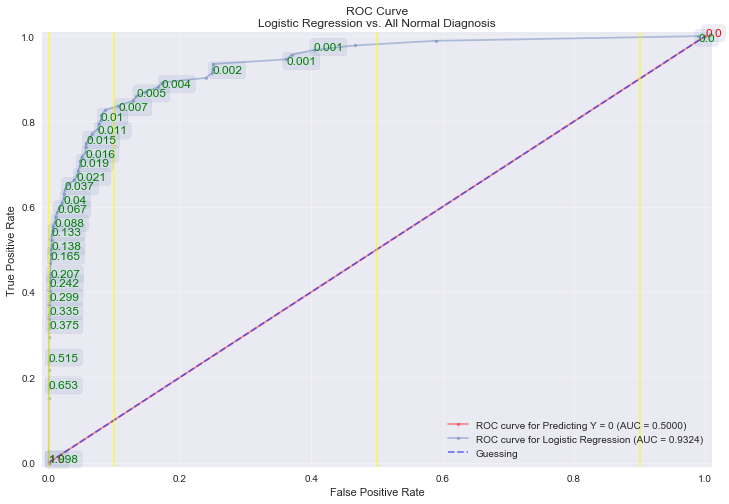

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import seaborn as sns

def compare_roc_curves(name, y_test, phat, phat_compare=None, compare_name=None, labe=5, skip=2, title='ROC'):
    '''
    Modified from lab ipynb for lab 7
    
    Inputs:
    ------------------------------------------------------
    name: name of the model being plotted
    y_test: true values of y_test
    phat: probabilities of yhat of model in question
    phat_compare: probabilities of any model comparing w/ phat model
    compare_name: name of comparison model
    labe: skipping for labels on plot
    skip: skipping for plot
    title: title of plot
    
    
    Outputs:
    ------------------------------------------------------
    ax: matplotlib.pyplot ax object for further modifications
    '''
    fig, ax = plt.subplots(figsize=(12, 8))

    fpr, tpr, thresholds = roc_curve(y_test, phat)
    roc_auc = auc(fpr, tpr)
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.1)

    if phat_compare != None:
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_test, phat_compare)
        roc_auc_0 = auc(fpr_0, tpr_0)
        ax.plot(fpr_0, tpr_0, '.-', alpha=0.4, c='red', \
                label='ROC curve for %s (AUC = %0.4f)' % (compare_name, roc_auc_0))
        for k in range(0, fpr_0.shape[0]):
            threshold_0 = str(np.round(thresholds_0[k], 3))
            ax.annotate(threshold_0, (fpr_0[k], tpr_0[k]), color='red', **label_kwargs)

    ax.plot(fpr[0:fpr.shape[0]:skip], tpr[0:fpr.shape[0]:skip], '.-', alpha=0.4, \
           label='ROC curve for %s (AUC = %0.4f)' % (name, roc_auc))

    for k in range(0, fpr.shape[0], labe):
        threshold = str(np.round(thresholds[k], 3))
        ax.annotate(threshold, (fpr[k], tpr[k]), color='green', **label_kwargs)

    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.grid(alpha=0.3)
    plt.style.use('seaborn-whitegrid')
    ax.set_title(title)
    ax.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), 'b--', alpha=0.5, label='Guessing')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.style.use('seaborn-whitegrid')

    return ax


# get p-hats
phat_logit = logit.predict_proba(datasets['complete']['x_test'])[:, 1]

ax = compare_roc_curves('Logistic Regression', datasets['complete']['y_test'], phat_logit, \
                   yhat_zeros, 'Predicting Y = 0', labe=5, \
                   skip=2, title='ROC Curve\nLogistic Regression vs. All Normal Diagnosis')

for v in [0, 0.1, 0.5, 0.9]:
    ax.axvline(v, c='yellow', label='FPR Threshold', alpha=0.6)

In [6]:
round_list = lambda ls, n: [round(l, n) for l in ls]

def max_tpr_given_fpr(y_actual, p_hat):
    '''
    Inputs:
    ------------------------------------------------------
    y_actual:
    p_hat: predicted probabilities
   
    Outputs:
    ------------------------------------------------------
    df: pd.DataFrame of tpr, fpr and thresholds (as index)
    '''
    fpr, tpr, thresholds = roc_curve(y_actual, p_hat)
    fpr, tpr = round_list(fpr, 3), round_list(tpr, 3)
    df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}).set_index('thresholds', drop=True)
   
    return df
 
# useful ideas and understanding gained from
# https://blogs.sas.com/content/iml/2011/07/29/computing-an-roc-curve-from-basic-principles.html
logit_tprfpr_df = max_tpr_given_fpr(datasets['complete']['y_test'], phat_logit)
normal_tprfpr_df = max_tpr_given_fpr(datasets['complete']['y_test'], phat_zeros)

# cherry pick closest values to the ones specified in the prompt
tpr_fpr0 = logit_tprfpr_df.loc[(logit_tprfpr_df.fpr>=0.0) & (logit_tprfpr_df.fpr<=0.00001)].head(1)
tpr_fpr10 = logit_tprfpr_df.loc[(logit_tprfpr_df.fpr>=0.1001) & (logit_tprfpr_df.fpr<=0.110)].head(1)
tpr_fpr50 = logit_tprfpr_df.loc[(logit_tprfpr_df.fpr>=0.47) & (logit_tprfpr_df.fpr<=0.59)].head(1)
tpr_fpr90 = logit_tprfpr_df.loc[(logit_tprfpr_df.fpr>=0.80) & (logit_tprfpr_df.fpr<=0.99)].head(1)
pd.concat([tpr_fpr0, tpr_fpr10, tpr_fpr50, tpr_fpr90], axis=0)

,fpr,tpr
thresholds,,
1.997902e+00,0.000,0.000
7.307838e-03,0.106,0.826
2.071622e-04,0.589,0.978
9.030874e-08,0.990,0.989



Original optimal threshold = 0.0046
Optimal threshold divided in half = 0.0023


    Confusion Matrix for Model: Using 0.33 as Cutoff for Positive Test Logistic Regression
    ------------------------------------------------------
              Negative  Positive  Total
TestNegative     17165        60  17225
TestPositive        18        32     50
Total            17183        92  17275

    Metrics for Model: Using 0.33 as Cutoff for Positive Test Logistic Regression
    ------------------------------------------------------
    Accuracy Rate = 0.99548
    Misclassification Rate = 0.00452
    False Positive Rate (Fall-Out, False Alarm, Type I Error) = 0.00105
    False Negative Rate (Miss, Type II Error) = 0.65217
    True Positive Rate (Sensitivity, Recall, Hit) = 0.34783
    True Negative Rate (Specificity) = 0.99895
    Prevalence Rate = 0.00533
    Positive Predictive Value (Precision) = 0.64000
    Negative Predictive Value = 0.99652
    False Discovery Rate = 0.36000
    False

/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


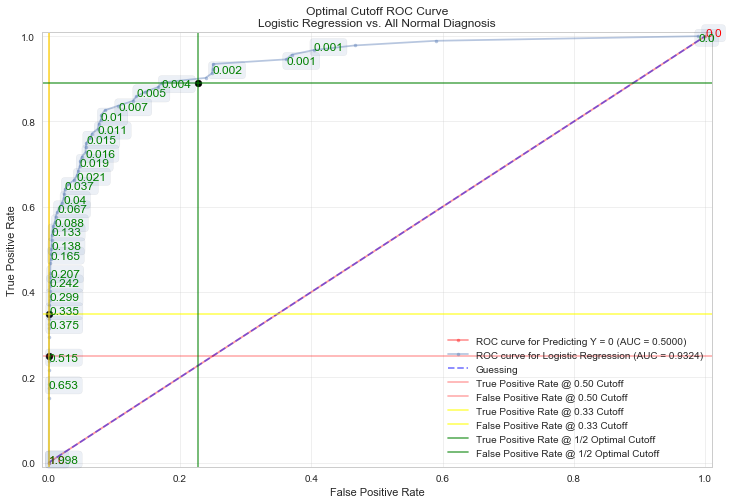

In [7]:
def find_optimal_cutoff(y_test, y_hat):
    '''
    Modified from:
    https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    
    Inputs:
    ------------------------------------------------------
    y_test: labels (actual)
    y_hat: estimated labels
    
    Outputs:
    ------------------------------------------------------
    roc_t: optimal cutoff
    roc: full dataset
    '''
    # The optimal cut off would be where tpr is high and fpr is low
    # tpr - (1-fpr) is zero or near to zero is the optimal cut off point
    
    fpr, tpr, threshold = roc_curve(y_test, y_hat)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf':pd.Series(tpr - (1-fpr), index=i), \
                       'threshold':pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
    roc_t = list(roc_t['threshold'])
    
    return roc_t, roc

# reclassify phat as 0,1 based on 0.33 cutoff
cutoff = lambda x, opt_threshold: 1 if x > opt_threshold else 0
cutoff33_yhat = [cutoff(p, .33333) for p in phat_logit]

# find optimal threshold
opt_threshold, roc_df = find_optimal_cutoff(datasets['complete']['y_test'], phat_logit)

# find threshold weighting false positives 2x as much
print('''
Original optimal threshold = %.4f
Optimal threshold divided in half = %.4f
''' %(opt_threshold[0], opt_threshold[0]/2))
opt_threshold = opt_threshold[0] / 2
opt_yhat_2xfp = [cutoff(p, opt_threshold) for p in phat_logit]

#compare_roc_curves('Optimal', datasets['complete']['y_test'], opt_phat)

cm_logit_opt, metrics_logit_opt = binary_confusion_matrix(datasets['complete']['y_test'], \
                                                  cutoff33_yhat, model_name='Using 0.33 as Cutoff for Positive Test Logistic Regression')
cm_logit_opt_2xfp, metrics_logit_opt_2xfp = binary_confusion_matrix(datasets['complete']['y_test'], \
                                                  opt_yhat_2xfp, \
                                                  model_name='Using Half the Optimal Cutoff Logistic Regression')


# compare the models with different cutoffs 
ax = compare_roc_curves('Logistic Regression', datasets['complete']['y_test'], phat_logit, \
                   yhat_zeros, 'Predicting Y = 0', labe=5, \
                   skip=2, title='Optimal Cutoff ROC Curve\nLogistic Regression vs. All Normal Diagnosis')

ax.axhline(metrics_logit['true_positive'], alpha=0.3, c='red', label='True Positive Rate @ 0.50 Cutoff')
ax.axvline(metrics_logit['false_positive'], alpha=0.3, c='red', label='False Positive Rate @ 0.50 Cutoff')
ax.scatter(metrics_logit['false_positive'], metrics_logit['true_positive'], c='black')

ax.axhline(metrics_logit_opt['true_positive'], alpha=0.6, c='yellow', label='True Positive Rate @ 0.33 Cutoff')
ax.axvline(metrics_logit_opt['false_positive'], alpha=0.6, c='yellow', label='False Positive Rate @ 0.33 Cutoff')
ax.scatter(metrics_logit_opt['false_positive'], metrics_logit_opt['true_positive'], c='black')

ax.axhline(metrics_logit_opt_2xfp['true_positive'], alpha=0.6, c='green', label='True Positive Rate @ 1/2 Optimal Cutoff')
ax.axvline(metrics_logit_opt_2xfp['false_positive'], alpha=0.6, c='green', label='False Positive Rate @ 1/2 Optimal Cutoff')
ax.scatter(metrics_logit_opt_2xfp['false_positive'], metrics_logit_opt_2xfp['true_positive'], c='black')

ax.legend(loc='best')

print('''
Using 1/2 optimal cutoff = %.6f
---------------------------------------
True positive rate = %.4f
False positive rate = %.4f
''' %(opt_threshold, metrics_logit_opt_2xfp['true_positive'], metrics_logit_opt_2xfp['false_positive']))

### Comparing ROC Curves

It is observed that the $Y=0$ model has an ROC curve that is a 45 degree line from 0 to 1, whereas the logistic regression model hugs the upper left corner and increases at a decreasing rate.

### Highest $TPR$ at Different $FPR$ Values

Below are the highest $TPR$s that are observed at $FPR$ approximately equal to ${0.0, 0.1, 0.5, 0.9}$ based on the model in question.  It is observed that as $FPR$ increases the threshold for positive identification decreases.  This makes intuitive sense because a lower threshold is essentially more open to both false positives and true positives due to the fact that it is predicting that a greater portion of the sample belongs to the positive group the lower the threshold goes.  These thresholds are shown as vertical yellow lines on the first plot shown above.

|thresholds	  |	fpr   |	  tpr  |
|------------------------------|
|1.997905e+00 |	0.000 |	0.000  |
|7.308165e-03 |	0.106 |	0.826  |
|2.071465e-04 |	0.589 |	0.978  |
|9.035209e-08 |	0.990 |	0.989  |

### False Negatives: *Twice as Critical an Error* as False Positives in Cancer Diagnosis

Should a clinician specify that a $FN$ error is twice as costly/critical than a $FP$ error, one could adjust the cutoff from 0.50 to another value that makes it less likely to achieve a high false negative rate.  

Taking the naive approach, one could simply adjust the decision threshold cutoff to 0.33 from logistic regression's 0.50 (such that 0.67 is twice as large as 0.33), effectively classifying anybody with above a 33% probability of having cancer as a positive test result.  As shown in the plot above, both the 50% cutoff (shown in red) and the 33% cutoff (shown in yellow) both do a poor job of correctly identifying diseased patients: the 50% cutoff has a $TPR$ around 25% while the cutoff at 33% has a $TPR$ around 35%.  While this approach increases the $TPR$ considerably it still does a poor job of correctly identifying diseased patients as such.  Since there are almost no false positive errors indicates there is room for improvement on this approach.

A more enlightened approach involves finding the optimal cutoff, defined as the point where $TPR$ is high and $FPR$ is low or $TPR - (1-FPR) ~ 0$, then shrinking this cutoff to half its size to penalize false negative errors more than false positive errors.  Given the low prevalence of disease the optimal threshold is found to be 0.0046, thus classifying anyone with a probability above this threshold as positive.  Cutting this in half (to give higher weight to the cost of false negatives) we get 0.0023 as a cutoff.  While this does not lead to a ratio of precisely 2 of $\frac{FNR}{FPR}$ it does come very close with $FPR=0.22674$ and $FNR=0.10870$.  The model as adjusted with this threshold performs relatively well (is shown in green above) and returns a $TPR = 0.8913$ and $FPR = 0.2267$.

|$\frac{\hat p^*}{2}$ Cutoff |Negative  |Positive  |Total|
|----------------------------|----------|----------|-----|
|TestNegative                |   13287  |      10  |13297|
|TestPositive                |    3896  |      82  | 3978|
|Total                       |   17183  |      92  |17275|


### Comparing AUC for All 0's & Logistic Regression Models

The two models area under the curve $AUC$ metrics are displayed below.

- AUC for Logistic Regression = 0.9324
- AUC for $Y=0$ Model = 0.5000

These same two models have very similar accuracy rates, with logistic regression's at 99.6% and the $Y=0$ model's at 99.5%, yet their $AUC$ scores are drastically different.  The high accuracy scores are an artifact of the low prevalence of disease in the data and are not reflective of model quality.  $AUC$, however, does reflect model quality.  Logistic regression's $AUC=0.9324$ is strictly better than the $Y=0$ model's $AUC=0.500$ (which is equivalent to random guessing).  This means the logistic regression model has a higher probability that a randomly chosen diseased patient has a higher probability of being positive than a randomly chosen non-diseased patient.  Comparing $AUC$ effectively highlights the differences in the models much better than model accuracy does. 

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [8]:
# read in data w/ missing values - make fn to do it
def read_missing_data(path=path):
    '''For constantly re-reading in data'''
    df_miss = pd.read_csv(path + 'hw6_dataset_missing.csv', header=0, index_col=0)
    
    return df_miss


    Out of 118 total columns in the new dataset there are 17 columns with missing values.
    


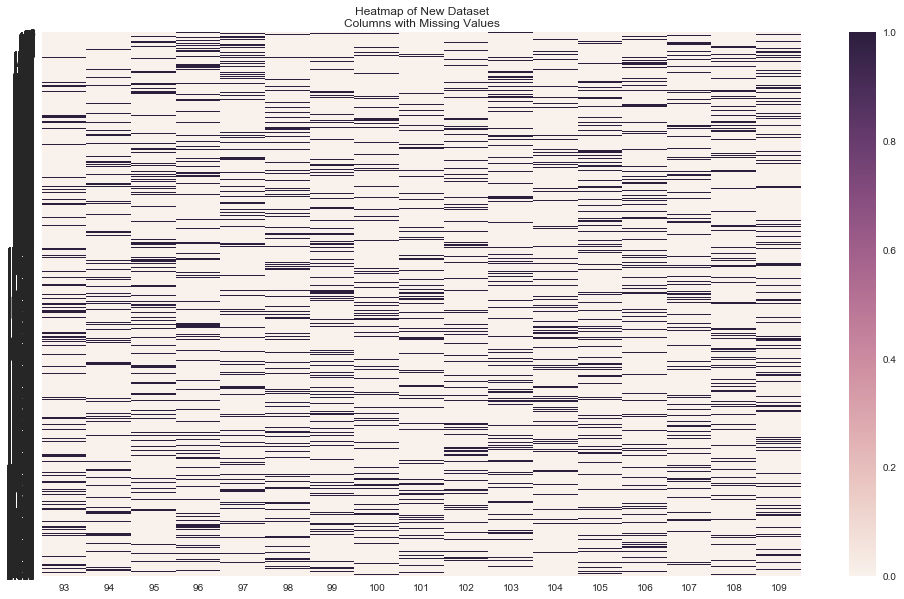

In [9]:
def id_cols_with_nas(df_miss):
    '''
    Inputs:
    ------------------------------------------------------
    df_miss: pd.DataFrame with missing values
    
    Outputs:
    ------------------------------------------------------
    missing_df: description of cols with missing data
    '''
    cols_w_missing = [col for col in df_miss.columns if np.sum(df_miss[col].isnull() == True) > 0]

    print('''
    Out of %i total columns in the new dataset there are %i columns with missing values.
    ''' %(len(df_miss.columns), len(cols_w_missing)))

    n_missing = [np.sum(df_miss[col].isnull()==True) for col in cols_w_missing]
    miss_data = {'col_with_missing_values':cols_w_missing, 'n_missing':n_missing, 'pct_missing':np.divide(n_missing, len(df_miss.index))}
    missing_df = pd.DataFrame(miss_data).set_index('col_with_missing_values')

    return missing_df, cols_w_missing

df_miss = read_missing_data()
missing_cols_pct, cols_w_missing = id_cols_with_nas(df_miss)

fig, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(df_miss[cols_w_missing].isnull() == True)
ax.set_title('Heatmap of New Dataset\nColumns with Missing Values')

In [10]:
# drop all NA rows, split and save to datasets dictionary
df_missing = read_missing_data(path).dropna()

# id X and Y cols
x_cols = df_missing.columns[:-1]
y_col = df_missing.columns[-1]

datasets['drop_all_missing'] = train_test_split_shape(df_missing, x_cols, y_col, train_size=0.75)

# id parameters
param_grid = {'C': [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]}#{'C': [.0001, .001, .01, .1, 1, 10, 100, 1000]}

# gridsearch to find best C value
logit_incomplete = LogisticRegression(penalty='l2')
logit_incomplete = GridSearchCV(logit_incomplete, param_grid)

# fit on full train data
logit_incomplete.fit(datasets['drop_all_missing']['x_train'], datasets['drop_all_missing']['y_train'])

# get yhat
yhat_logit_incomplete = logit_incomplete.predict(datasets['drop_all_missing']['x_test'])

# get confusion matrix
cm_logit_incomplete, metrics_logit_incomplete = binary_confusion_matrix(datasets['drop_all_missing']['y_test'], \
                                                                        yhat_logit_incomplete, \
                                                                        model_name='Logistic Regression - Dropped Missing Rows')


    Shape of Training Data w/ Missing Values:
    ------------------------------------------------------
    X: (1077, 117)
    Y: (1077,)

    Shape of Testing Data w/ Missing Values:
    ------------------------------------------------------
    X: (359, 117)
    Y: (359,)
    


/Users/pmw/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



    Confusion Matrix for Model: Logistic Regression - Dropped Missing Rows
    ------------------------------------------------------
              Negative  Positive  Total
TestNegative       358         1    359
TestPositive         0         0      0
Total              358         1    359

    Metrics for Model: Logistic Regression - Dropped Missing Rows
    ------------------------------------------------------
    Accuracy Rate = 0.99721
    Misclassification Rate = 0.00279
    False Positive Rate (Fall-Out, False Alarm, Type I Error) = 0.00000
    False Negative Rate (Miss, Type II Error) = 1.00000
    True Positive Rate (Sensitivity, Recall, Hit) = 0.00000
    True Negative Rate (Specificity) = 1.00000
    Prevalence Rate = 0.00279
    Positive Predictive Value (Precision) = nan
    Negative Predictive Value = 0.99721
    False Discovery Rate = nan
    False Omission Rate = 0.00279
    


/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [11]:
# re-read in for mean imputation
df_missing = read_missing_data(path)
df_missing[cols_w_missing] = df_missing[cols_w_missing].fillna(df_missing[cols_w_missing].mean())

# save to central dataset dict
datasets['impute_mean'] = train_test_split_shape(df_missing, x_cols, y_col, train_size=0.75)

# id parameters
param_grid = {'C': [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]}#{'C': [.0001, .001, .01, .1, 1, 10, 100, 1000]}

# gridsearch to find best C value
logit_mean = LogisticRegression(penalty='l2')
logit_mean = GridSearchCV(logit_mean, param_grid)

# fit on full train data
logit_mean.fit(datasets['impute_mean']['x_train'], datasets['impute_mean']['y_train'])

# get yhat
yhat_logit_mean = logit_mean.predict(datasets['impute_mean']['x_test'])

# get confusion matrix
cm_logit_mean, metrics_logit_mean = binary_confusion_matrix(datasets['impute_mean']['y_test'], \
                                                                        yhat_logit_mean, \
                                                                        model_name='Logistic Regression - Imputed Mean Values')


    Shape of Training Data w/ Missing Values:
    ------------------------------------------------------
    X: (18749, 117)
    Y: (18749,)

    Shape of Testing Data w/ Missing Values:
    ------------------------------------------------------
    X: (6250, 117)
    Y: (6250,)
    

    Confusion Matrix for Model: Logistic Regression - Imputed Mean Values
    ------------------------------------------------------
              Negative  Positive  Total
TestNegative      6200        33   6233
TestPositive         5        12     17
Total             6205        45   6250

    Metrics for Model: Logistic Regression - Imputed Mean Values
    ------------------------------------------------------
    Accuracy Rate = 0.99392
    Misclassification Rate = 0.00608
    False Positive Rate (Fall-Out, False Alarm, Type I Error) = 0.00081
    False Negative Rate (Miss, Type II Error) = 0.73333
    True Positive Rate (Sensitivity, Recall, Hit) = 0.26667
    True Negative Rate (Specificity) = 0.9

In [12]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

# re-read in data with missing values for model-based imputation
df_missing = read_missing_data(path)

# use ridge regression to impute the data
complete_columns = [col for col in df_missing.columns if col not in cols_w_missing]

for col in cols_w_missing:
    # find good ridge model for each column
    ridge_lm = RidgeCV(alphas=[.001, .01, 1, 10., 100., 1000.]) #LassoCV(alphas=[.001, .01, 1, 10., 100., 1000.])
    
    # id which indices are not missing for target
    not_missing = df_missing[col].isnull() == False
    
    # fit model on complete columns, same index as not missing
    x_temp = df_missing.loc[not_missing, complete_columns]
    y_temp = df_missing.loc[not_missing, col]
    ridge_lm.fit(x_temp, y_temp)
    
    # predict on non-missing vals
    yhat_ridge = ridge_lm.predict(df_missing.loc[~not_missing, complete_columns].values)
    
    # run KNN regressor using gridsearch, fit model
    #param_grid_knn = {'n_neighbors':[8, 16, 32]}
    #knn = KNeighborsRegressor()
    #knn = GridSearchCV(knn, param_grid_knn)
    #knn.fit(x_temp, y_temp)
    
    # predict on non-missing vals
    #yhat_knn = knn.predict(df_missing.loc[~not_missing, complete_columns].values)
    
    # compile two yhat vectors into one pd.DataFrame and average by rows
    #yhat = pd.DataFrame({'ridge':yhat_ridge, 'knn':yhat_knn}).mean(axis=1).values
    df_missing.loc[~not_missing, col] = yhat_ridge #y_hat
    
    # add to complete columns since it is imputed
    complete_columns.append(col)

# save to central dataset dict
datasets['impute_model'] = train_test_split_shape(df_missing, x_cols, y_col, train_size=0.75)

# id parameters
param_grid = {'C': [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]}

# gridsearch to find best C value
logit_impute_model = LogisticRegression(penalty='l2')
logit_impute_model = GridSearchCV(logit_impute_model, param_grid)

# fit on full train data
logit_impute_model.fit(datasets['impute_model']['x_train'], datasets['impute_model']['y_train'])

# get yhat
yhat_logit_impute_model = logit_incomplete.predict(datasets['impute_model']['x_test'])

# get confusion matrix
cm_logit_impute_model, metrics_logit_impute_model = binary_confusion_matrix(datasets['impute_model']['y_test'], \
                                                                        yhat_logit_impute_model, \
                                                                        model_name='Logistic Regression - Missing Values Imputed w/ RidgeCV & KNN (Averaged)')


    Shape of Training Data w/ Missing Values:
    ------------------------------------------------------
    X: (18749, 117)
    Y: (18749,)

    Shape of Testing Data w/ Missing Values:
    ------------------------------------------------------
    X: (6250, 117)
    Y: (6250,)
    

    Confusion Matrix for Model: Logistic Regression - Missing Values Imputed w/ RidgeCV & KNN (Averaged)
    ------------------------------------------------------
              Negative  Positive  Total
TestNegative      6205        44   6249
TestPositive         1         0      1
Total             6206        44   6250

    Metrics for Model: Logistic Regression - Missing Values Imputed w/ RidgeCV & KNN (Averaged)
    ------------------------------------------------------
    Accuracy Rate = 0.99280
    Misclassification Rate = 0.00720
    False Positive Rate (Fall-Out, False Alarm, Type I Error) = 0.00016
    False Negative Rate (Miss, Type II Error) = 1.00000
    True Positive Rate (Sensitivity, Rec

### Comparison of Imputation Methods

As is shown in the heatmap above, which highlights all missing values in the original data, the missingness is not clustered in any sort of way with the observations' row index.  This means that dropping all observations that have missing values in any feature drastically diminishes the size of both datasets -- reducing the number of observations from 18749 to 1077 for the training set and from 6250 to 359 for the test set -- leaving too few observations to provide a sufficient number of positive examples for the algorithm to be able to generalize effectively.  

--------------------------------------------
|Drop Missing    |Negative  |Positive  |Total|
|----------------|----------|----------|-----|
|TestNegative    |     358  |       1  |  359|
|TestPositive    |       0  |       0  |    0|
|Total           |     358  |       1  |  359|

|Imputing Mean   |Negative  |Positive  |Total|
|----------------|----------|----------|-----|
|TestNegative    |    6200  |      33  | 6233|
|TestPositive    |       5  |      12  |   17|
|Total           |    6205  |      45  | 6250|

|Impute w/ Model |Negative  |Positive  |Total|
|----------------|----------|----------|-----|
|TestNegative    |     6205 |      44  | 6249|
|TestPositive    |        1 |       0  |   1 |
|Total           |     6206 |      44  | 6250|
--------------------------------------------

The mean imputation model performs considerably better and has very low computational complexity compared to more complicated imputation techniques.

The final imputation model was tested using three techniques: `LassoCV`, `RidgeCV` and `RidgeCV` averaged with cross-validated `KNeighborsRegressor`.  The approach of averaging together results from `RidgeCV` and `KNeighborsRegressor` was abandoned due to long compute time, and while both  `RidgeCV` & `LassoCV` performed similarly,  `RidgeCV` was chosen due to the desireable characteristic that it did not shrink the coefficients to zero.  

It is conjectured that mean imputation performed best because the features with missing values may not have been related (and therefore predictable) from the features with non-missing values.  

## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.
